In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [26]:
# os.path entrega funcionalidades relacionadas a paths (rutas) de ficheros

from os.path import join
ruta_csv = join("data", "hipparcos-voidmain.csv")
hipp_df = pd.read_csv(ruta_csv)


In [27]:
# que columnas son objetos
# y pueden requerir tratamiento especial
obj_columns = hipp_df.columns[hipp_df.dtypes == object]

Un truco si queremos pasar directamente a ver los datos que es posible describir numericamente, es hacer un `describe` al dataset, todas las variables que no sean compatibles con esta operacion numerica seran ignoradas.

Podemos tomar `.columns` de este objeto para ver cuales columnas sobrevivieron

In [28]:
columnas_numericas = hipp_df.describe().columns
columnas_numericas

Index(['HIP', 'Vmag', 'VarFlag', 'RAdeg', 'DEdeg', 'Plx', 'pmRA', 'pmDE',
       'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA', 'Plx:RA',
       'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE',
       'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', '---', 'BTmag', 'e_BTmag', 'VTmag',
       'e_VTmag', 'B-V', 'e_B-V', 'V-I', 'e_V-I', 'Hpmag', 'e_Hpmag', 'Hpscat',
       'o_Hpmag', 'Hpmax', 'HPmin', 'Period', 'moreVar', 'Nsys', 'Ncomp',
       'theta', 'rho', 'e_rho', 'dHp', 'e_dHp', 'HD', '(V-I)red'],
      dtype='object')

Extraemos el tipo estelar que queremos finalmente tener a mano

In [54]:
# Definir los tipos espectrales estándar
standard_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Reemplazar los tipos no estándar con "Otros"
hipp_df['SpType_group_clean'] = hipp_df['SpType_group'].apply(lambda x: x if x in standard_types else 'Otros')

# Ver la nueva distribución de los tipos espectrales
spectral_type_clean_counts = hipp_df['SpType_group_clean'].value_counts()

# Mostrar la distribución
print(spectral_type_clean_counts)


SpType_group_clean
K        32036
F        25607
G        22771
A        18704
B        10421
M         4862
Otros     3552
O          265
Name: count, dtype: int64


In [56]:
y = hipp_df['SpType_group_clean'].astype('category').cat.codes
y.shape


(118218,)

In [57]:
y

0         2
1         4
2         1
3         2
4         3
         ..
118213    4
118214    3
118215    4
118216    3
118217    1
Length: 118218, dtype: int8

Ahora extraemos las variables numericas y a trabajar con ellas

In [30]:
X = hipp_df[columnas_numericas]
X.isna().sum()

HIP               0
Vmag              1
VarFlag      106656
RAdeg           263
DEdeg           263
Plx             263
pmRA            263
pmDE            263
e_RAdeg         263
e_DEdeg         263
e_Plx           263
e_pmRA          263
e_pmDE          263
DE:RA           263
Plx:RA          263
Plx:DE          263
pmRA:RA         263
pmRA:DE         263
pmRA:Plx        263
pmDE:RA         263
pmDE:DE         263
pmDE:Plx        263
pmDE:pmRA       263
F1              263
F2             1826
---               0
BTmag          3398
e_BTmag        3398
VTmag          3339
e_VTmag        3339
B-V            1281
e_B-V          1281
V-I            1275
e_V-I          1275
Hpmag            14
e_Hpmag          14
Hpscat          971
o_Hpmag         971
Hpmax           971
HPmin           971
Period       115677
moreVar      109964
Nsys          98825
Ncomp           263
theta        107117
rho          107117
e_rho        107117
dHp          107117
e_dHp        107117
HD            19338


El proceso de tratar los `not a number`, vamos a eliminar los que son demasiados y llenar con la media aquellos que son menos

In [31]:
import pandas as pd

# Supongamos que hipp_df es tu DataFrame con los datos de Hipparcos

# 1. Eliminar columnas con más de 50,000 valores faltantes
cols_to_drop = X.columns[X.isna().sum() > 50000]
X = X.drop(columns=cols_to_drop)

# 2. Rellenar los valores faltantes en las columnas restantes con la media
X.fillna(X.mean(), inplace=True)

# Verificar que se eliminaron las columnas y se rellenaron los NaN
print(X.isna().sum().sum())


0


In [32]:
print(X.shape)
print(y.shape)

(118218, 42)
(118218,)


# Reducción Dimensionalidad

In [33]:
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

Ahora lo que tenemos son unas enormes 42 columnas de datos, por ello queremos ser capaces de comprimir toda esa información en un espacio más reducido.

Para lograr eso y con una buena eficiencia es buena idea escalar los datos, algunos valores pueden ir en 1000's y otros entre 0 y 1, cosa que hace que sean dificiles de comparar, por ello hemos de usar herramientas como `StandardScaler`

In [34]:
X = StandardScaler().fit_transform(X)

Crear un PCA con 2 componentes para poder graficar y observar los datos

In [36]:
# Aplicar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Información sobre la varianza explicada
# Imprimir la varianza explicada por los dos primeros componentes en porcentaje
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"Componente Principal {i + 1}: {var * 100:.2f}% de la varianza explicada")


Componente Principal 1: 17.82% de la varianza explicada
Componente Principal 2: 9.61% de la varianza explicada


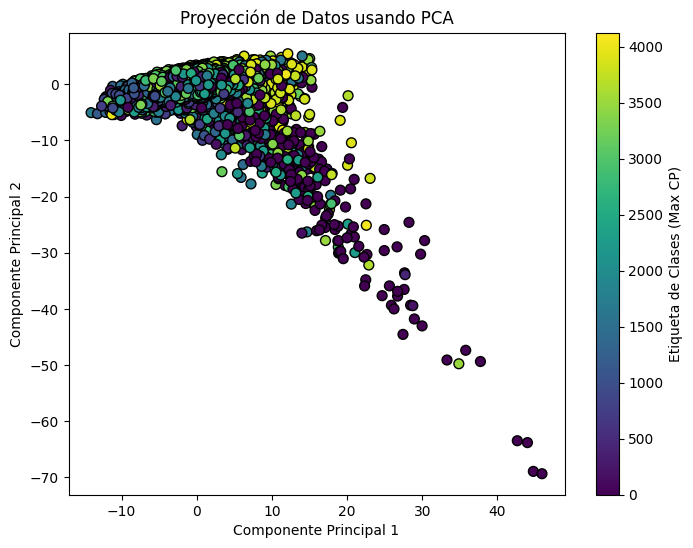

In [37]:
# Graficar los datos proyectados en el nuevo subespacio de 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección de Datos usando PCA')
plt.colorbar(label='Etiqueta de Clases (Max CP)')
plt.show()


Como maximo los humanos podemos entender 3 dimensiones sin confusión, por tanto podriamos tomar 3 componentes y observar como se dividen en el espacio.

Componente Principal 1: 17.82% de la varianza explicada
Componente Principal 2: 9.61% de la varianza explicada
Componente Principal 3: 9.41% de la varianza explicada


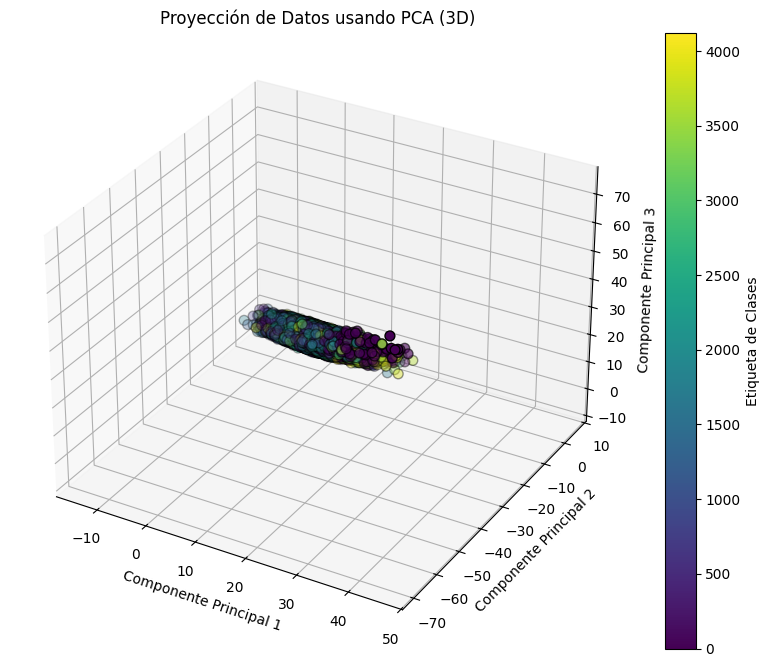

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicar PCA para reducir a 3 componentes principales
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Información sobre la varianza explicada
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"Componente Principal {i + 1}: {var * 100:.2f}% de la varianza explicada")

# Graficar los datos proyectados en el nuevo subespacio de 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear el gráfico 3D
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', s=50, edgecolor='k')

# Etiquetas de los ejes
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Proyección de Datos usando PCA (3D)')

# Añadir barra de colores para representar las clases
plt.colorbar(sc, label='Etiqueta de Clases')

# Mostrar la gráfica
plt.show()

Sin embargo hemos observado que PCA la cual es una tecnica lineal, mantiene muy poca varianza con tan pocos componentes

Es posible alternativamente definir cuanta varianza queremos mantener

In [65]:
# scikit-learn elige el numero minimo de componentes para mantener una varianza del 95%
pca = PCA(0.95)
pca.fit(X)
print("numero de componentes de PCA:", pca.n_components_)

X_pca = pca.transform(X)

numero de componentes de PCA: 24


# Utilizar el PCA para correr otros algoritmos de clasificacion

In [67]:

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split



In [68]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

svm_clf = svm.SVC(kernel='rbf', C=1)
svm_clf.fit(X_train, y_train)
score = svm_clf.score(X_val, y_val)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.784


In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.33, random_state = 42)

svm_clf = svm.SVC(kernel='rbf', C=1)
svm_clf.fit(X_train, y_train)
score = svm_clf.score(X_val, y_val)
svm_score_ = np.mean(score)

print('Accuracy : %.3f' % (svm_score_))

Accuracy : 0.778


# Otras reducciones de Dimensionalidad

<a id="Incremental PCA"></a>
### <u> Incremental PCA </u>

PCA requires the whole training set to fit in memory. Incremental PCA splits the training set into mini-batches. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new instances arrive).

In [41]:
from sklearn.decomposition import IncrementalPCA

n_batches = 10
inc_pca = IncrementalPCA(n_components=10)

for X_batch in np.array_split(X, n_batches):
        inc_pca.partial_fit(X_batch)
        
X_reduced = inc_pca.transform(X)

<a id="Aprendizaje de Variedades"></a>
## <u>Aprendizaje de Variedades</u>

<a id="t-SNE"></a>
### <u>t-SNE</u>

- t-SNE proyecta puntos en un espacio de alta dimensionalidad a una dimensión más baja de manera que las distancias entre los puntos permanezcan casi iguales.

- A diferencia del PCA, t-SNE no es una proyección lineal. Utiliza las relaciones locales entre puntos para crear un mapeo de baja dimensionalidad, lo que le permite capturar estructuras no lineales.
- t-SNE crea una distribución de probabilidad utilizando la distribución Gaussiana que define las relaciones entre los puntos en el espacio de alta dimensionalidad.
- t-SNE utiliza la distribución t de Student para recrear la distribución de probabilidad en el espacio de baja dimensionalidad.
- t-SNE optimiza las incrustaciones directamente usando descenso por gradiente. Sin embargo, la función de costo no es convexa, lo que significa que existe el riesgo de quedarse atascado en mínimos locales. Esto tiene una consecuencia importante: t-SNE es no determinista. Al ejecutarlo varias veces, podemos obtener resultados diferentes en cada ocasión.

t-SNE utiliza “vecinos estocásticos”, lo que significa que no hay una línea clara que determine qué puntos son vecinos de otros. Esta falta de bordes claros permite que t-SNE tome en cuenta tanto la estructura global como la local de manera natural. La estructura local es más importante que la global, pero los puntos lejanos no se ignoran por completo, lo que permite una reducción de dimensionalidad "bien equilibrada".

#### <u>Algoritmo de t-SNE</u>:

<b>Paso 1</b>: En el espacio de alta dimensionalidad, crear una distribución de probabilidad que dicte las relaciones entre varios puntos vecinos.

<b>Paso 2</b>: Luego trata de recrear un espacio de baja dimensionalidad que siga dicha distribución de probabilidad lo mejor posible.

#### <u>¿Por qué necesitamos t-SNE?</u>

El PCA no puede capturar dependencias no lineales. Por ejemplo, PCA no sería capaz de "desenrollar" la siguiente estructura.


A linear projection is like casting a shadow. Unlike PCA, t-SNE is not limited to linear projections, which makes it suited to all sorts of datasets.

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
X_reduced = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100485 samples in 0.008s...
[t-SNE] Computed neighbors for 100485 samples in 72.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100485
[t-SNE] Computed conditional probabilities for sample 2000 / 100485
[t-SNE] Computed conditional probabilities for sample 3000 / 100485
[t-SNE] Computed conditional probabilities for sample 4000 / 100485
[t-SNE] Computed conditional probabilities for sample 5000 / 100485
[t-SNE] Computed conditional probabilities for sample 6000 / 100485
[t-SNE] Computed conditional probabilities for sample 7000 / 100485
[t-SNE] Computed conditional probabilities for sample 8000 / 100485
[t-SNE] Computed conditional probabilities for sample 9000 / 100485
[t-SNE] Computed conditional probabilities for sample 10000 / 100485
[t-SNE] Computed conditional probabilities for sample 11000 / 100485
[t-SNE] Computed conditional probabilities for sample 12000 / 100485
[t-SNE] Computed conditional proba

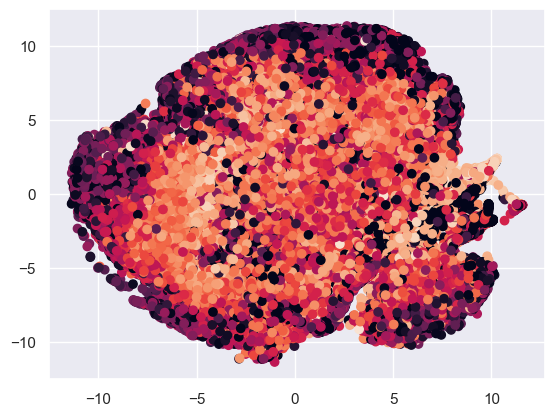

In [43]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue = y)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)

In [ ]:
tsne = TSNE(n_components=3, perplexity=40, max_iter=250)
X_reduced = tsne.fit_transform(X)

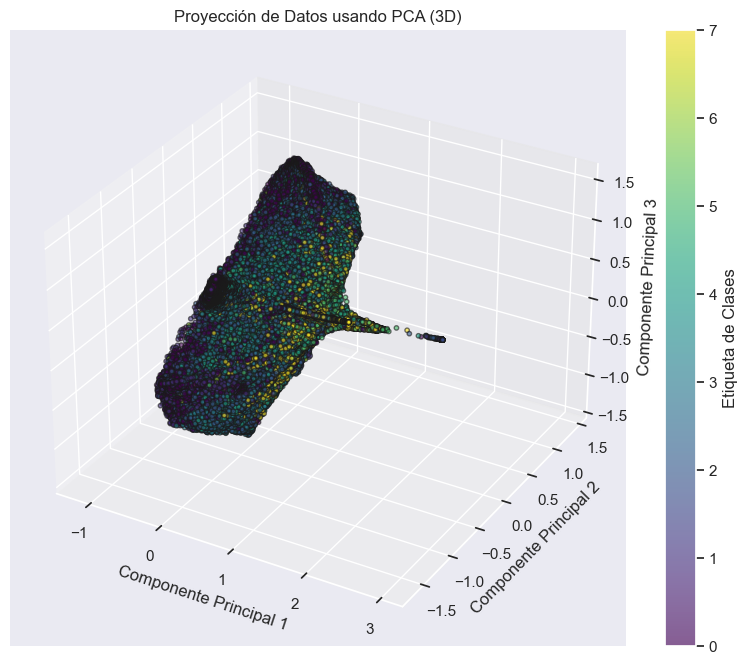

In [64]:
# Graficar los datos proyectados en el nuevo subespacio de 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear el gráfico 3D
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis', s=10, edgecolor='k', alpha=0.6)

# Etiquetas de los ejes
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Proyección de Datos usando PCA (3D)')

# Añadir barra de colores para representar las clases
plt.colorbar(sc, label='Etiqueta de Clases')

# Mostrar la gráfica
plt.show()